<a href="https://colab.research.google.com/github/shubham19999/Mask_Detection/blob/master/Mask_D_RetinaNet_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon May 25 06:41:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    41W / 250W |   8245MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
!git clone https://github.com/fizyr/keras-retinanet.git


Cloning into 'keras-retinanet'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 5736 (delta 12), reused 14 (delta 5), pack-reused 5705
Receiving objects: 100% (5736/5736), 13.37 MiB | 32.07 MiB/s, done.
Resolving deltas: 100% (3843/3843), done.


In [ ]:
!pip install --upgrade keras

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


In [ ]:
%cd keras-retinanet/

!pip install .

/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=169025 sha256=32ce1972243c21ad278e59ae97d2fd0a197b60fbe60fa7262eddbdedf049df41
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.1.0-py2.py3-none-any.whl size=13346 sha256=806515e97481f2f00f81297b680056f28879492844484af8f998a6e87faf35d8
  Stored in directory: /root/.cache/pip/wheels/80/dd/ac/842235b63dddac12faa4b48ebe58b8944e8c2e57c2e38dddb6
Successfully built keras-retinanet keras-resnet


In [ ]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/utils/compute_over

In [ ]:
!pip install gdown
!pip install tensorflow-gpu

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import urllib
import os
import csv
import cv2
import time
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
!pip install xmltodict
import xmltodict

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
def getImageNames():
    image_names = []
    for dirname, _, filenames in os.walk('/content/drive/My Drive/Unreal_AI/COVID-19/training'):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            extension = fullpath[len(fullpath) - 4:]
            if extension != '.xml' and (extension == '.jpg' or extension == 'jpeg'):
                image_names.append(filename)
    return image_names


def get_path(image_name):

  home_path = '/content/drive/My Drive/Unreal_AI/COVID-19/training/'
  image_path = home_path + 'images/' + image_name
    
  if image_name[-4:] == 'jpeg':
      label_name = image_name[:-5] + '.xml'
  else:
      label_name = image_name[:-4] + '.xml'
    
  label_path = home_path + 'annotations/' + label_name
        
  return  image_path, label_path

In [ ]:
image_names = getImageNames()

In [ ]:
len(image_names)

4391

In [ ]:
image_names[5]

'9_Press_Conference_Press_Conference_9_595.jpg'

In [ ]:
l = get_path(image_names[3404])[1]
l

'/content/drive/My Drive/Unreal_AI/COVID-19/training/annotations/test_00001420.xml'

In [ ]:
len(image_names)

4391

In [ ]:
dataset = dict()
dataset["image_name"] = list()
dataset["x_min"] = []
dataset["y_min"] = []
dataset["x_max"] = []
dataset["y_max"] = []
dataset["class_name"] = list()

for i in range (4391):
  image_path, label_path = get_path(image_names[i])
  
  x = xmltodict.parse(open(label_path , 'rb'))
  print(i)
  item_list = x['annotation']['object']
  try:
    item_list1 = item_list['bndbox']['xmin']
    item_list2 = item_list['bndbox']['ymin']
    item_list3 = item_list['bndbox']['xmax']
    item_list4 = item_list['bndbox']['ymax']
    item_list5 = item_list['name']

    dataset["x_min"].append(int(item_list1))
    dataset["y_min"].append(int(item_list2))
    dataset["x_max"].append(int(item_list3))
    dataset["y_max"].append(int(item_list4))
    dataset["class_name"].append(item_list5)
    dataset["image_name"].append(image_path)

  except:
    for item in item_list:
      item_list1 = item['bndbox']['xmin']
      item_list2 = item['bndbox']['ymin']
      item_list3 = item['bndbox']['xmax']
      item_list4 = item['bndbox']['ymax']
      item_list5 = item['name']

      dataset["x_min"].append(int(item_list1))
      dataset["y_min"].append(int(item_list2))
      dataset["x_max"].append(int(item_list3))
      dataset["y_max"].append(int(item_list4))
      dataset["class_name"].append(item_list5)
      dataset["image_name"].append(image_path)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
print(len(dataset['image_name']),
len(dataset['x_min']),
len(dataset['y_min']),
len(dataset['x_max']),
len(dataset['y_max']),
len(dataset['class_name']))

9539 9539 9539 9539 9539 9539


In [ ]:
df = pd.DataFrame(dataset)
df.head()

,image_name,x_min,y_min,x_max,y_max,class_name
0,/content/drive/My Drive/Unreal_AI/COVID-19/tra...,460,234,574,414,face
1,/content/drive/My Drive/Unreal_AI/COVID-19/tra...,435,216,630,531,face
2,/content/drive/My Drive/Unreal_AI/COVID-19/tra...,347,416,442,553,face_mask
3,/content/drive/My Drive/Unreal_AI/COVID-19/tra...,163,87,322,335,face_mask
4,/content/drive/My Drive/Unreal_AI/COVID-19/tra...,356,62,416,158,face


In [ ]:
for i in range (9539):
  if df['class_name'][i] == 'face_nask':
    df['class_name'][i] = 'face_mask'


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df['class_name'].unique()

array(['face', 'face_mask'], dtype=object)

In [ ]:
df.iloc[2751]

image_name    /content/drive/My Drive/Unreal_AI/COVID-19/tra...
x_min                                                       572
y_min                                                        76
x_max                                                       662
y_max                                                       179
class_name                                                 face
Name: 2751, dtype: object

In [ ]:
def show_image_objects(image_row):

  img_path = image_row.image_name
  box = [
    image_row.x_min, image_row.y_min, (image_row.x_max), (image_row.y_max)
  ]

  image = read_image_bgr(img_path)

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  draw_box(draw, box, color=(255, 255, 0))

  plt.axis('off')
  plt.imshow(draw)
  plt.show()

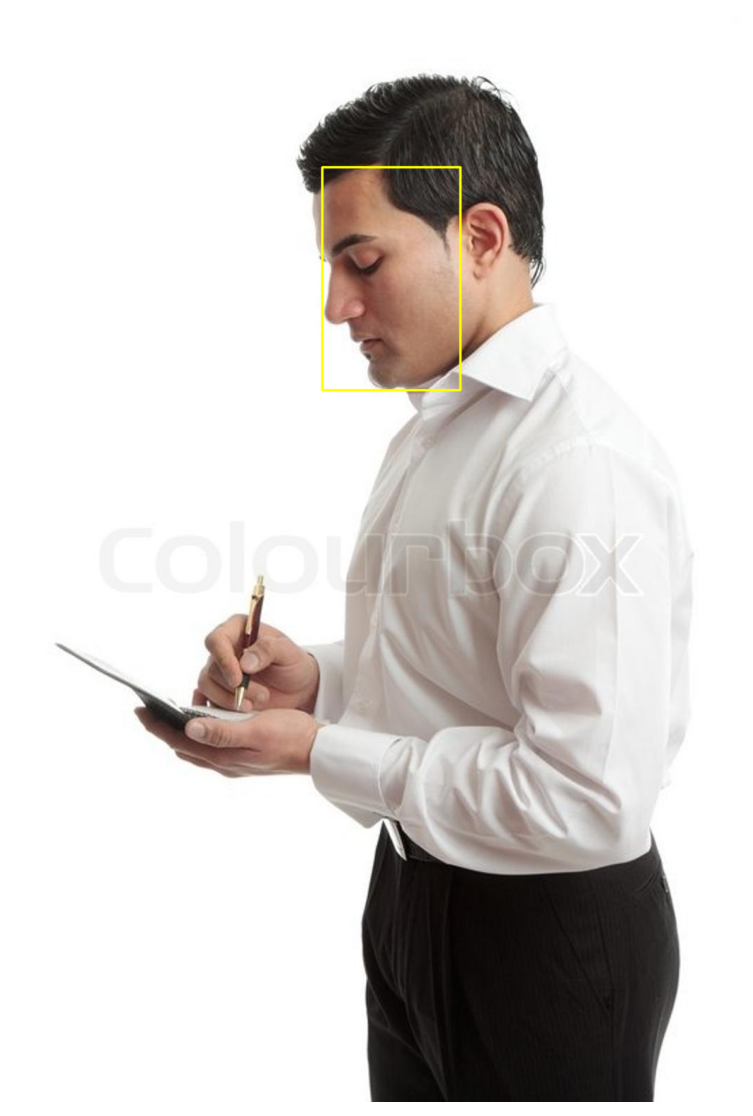

In [ ]:
show_image_objects(df.iloc[1])

In [ ]:
def getImageNamesval():
    image_names = []
    for dirname, _, filenames in os.walk('/content/drive/My Drive/Unreal_AI/COVID-19/validation'):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            extension = fullpath[len(fullpath) - 4:]
            if extension != '.xml' and (extension == '.jpg' or extension == 'jpeg'):
                image_names.append(filename)
    return image_names


def get_path_val(image_name):

  home_path = '/content/drive/My Drive/Unreal_AI/COVID-19/validation/'
  image_path = home_path + 'images/' + image_name
    
  if image_name[-4:] == 'jpeg':
      label_name = image_name[:-5] + '.xml'
  else:
      label_name = image_name[:-4] + '.xml'
    
  label_path = home_path + 'annotations/' + label_name
        
  return  image_path, label_path

In [ ]:
image_names_val = getImageNamesval()
len(image_names_val)

1585

In [ ]:
dataset_val = dict()
dataset_val["image_name"] = list()
dataset_val["x_min"] = []
dataset_val["y_min"] = []
dataset_val["x_max"] = []
dataset_val["y_max"] = []
dataset_val["class_name"] = list()

for i in range (1585):
  image_path, label_path = get_path_val(image_names_val[i])
  
  x = xmltodict.parse(open(label_path , 'rb'))
  print(i)
  item_list = x['annotation']['object']
  try:
    item_list1 = item_list['bndbox']['xmin']
    item_list2 = item_list['bndbox']['ymin']
    item_list3 = item_list['bndbox']['xmax']
    item_list4 = item_list['bndbox']['ymax']
    item_list5 = item_list['name']

    dataset_val["x_min"].append(int(item_list1))
    dataset_val["y_min"].append(int(item_list2))
    dataset_val["x_max"].append(int(item_list3))
    dataset_val["y_max"].append(int(item_list4))
    dataset_val["class_name"].append(item_list5)
    dataset_val["image_name"].append(image_path)

  except:
    for item in item_list:
      item_list1 = item['bndbox']['xmin']
      item_list2 = item['bndbox']['ymin']
      item_list3 = item['bndbox']['xmax']
      item_list4 = item['bndbox']['ymax']
      item_list5 = item['name']

      dataset_val["x_min"].append(int(item_list1))
      dataset_val["y_min"].append(int(item_list2))
      dataset_val["x_max"].append(int(item_list3))
      dataset_val["y_max"].append(int(item_list4))
      dataset_val["class_name"].append(item_list5)
      dataset_val["image_name"].append(image_path)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
df_val = pd.DataFrame(dataset_val)
df_val

,image_name,x_min,y_min,x_max,y_max,class_name
0,/content/drive/My Drive/Unreal_AI/COVID-19/val...,293,104,531,402,face_mask
1,/content/drive/My Drive/Unreal_AI/COVID-19/val...,306,43,662,507,face_mask
2,/content/drive/My Drive/Unreal_AI/COVID-19/val...,499,121,956,721,face_mask
3,/content/drive/My Drive/Unreal_AI/COVID-19/val...,147,54,290,275,face_mask
4,/content/drive/My Drive/Unreal_AI/COVID-19/val...,199,125,539,579,face_mask
...,...,...,...,...,...,...
3128,/content/drive/My Drive/Unreal_AI/COVID-19/val...,611,154,709,290,face
3129,/content/drive/My Drive/Unreal_AI/COVID-19/val...,805,146,901,296,face
3130,/content/drive/My Drive/Unreal_AI/COVID-19/val...,136,316,438,648,face
3131,/content/drive/My Drive/Unreal_AI/COVID-19/val...,572,220,794,528,face


In [ ]:
train_df = pd.concat([df, df_val])

In [ ]:
train_df

,image_name,x_min,y_min,x_max,y_max,class_name
0,/content/drive/My Drive/Unreal_AI/COVID-19/tra...,460,234,574,414,face
1,/content/drive/My Drive/Unreal_AI/COVID-19/tra...,435,216,630,531,face
2,/content/drive/My Drive/Unreal_AI/COVID-19/tra...,347,416,442,553,face_mask
3,/content/drive/My Drive/Unreal_AI/COVID-19/tra...,163,87,322,335,face_mask
4,/content/drive/My Drive/Unreal_AI/COVID-19/tra...,356,62,416,158,face
...,...,...,...,...,...,...
3128,/content/drive/My Drive/Unreal_AI/COVID-19/val...,611,154,709,290,face
3129,/content/drive/My Drive/Unreal_AI/COVID-19/val...,805,146,901,296,face
3130,/content/drive/My Drive/Unreal_AI/COVID-19/val...,136,316,438,648,face
3131,/content/drive/My Drive/Unreal_AI/COVID-19/val...,572,220,794,528,face


In [ ]:
train_df.iloc[1979]

image_name    /content/drive/My Drive/Unreal_AI/COVID-19/tra...
x_min                                                       547
y_min                                                       249
x_max                                                       572
y_max                                                       283
class_name                                                 face
Name: 1979, dtype: object

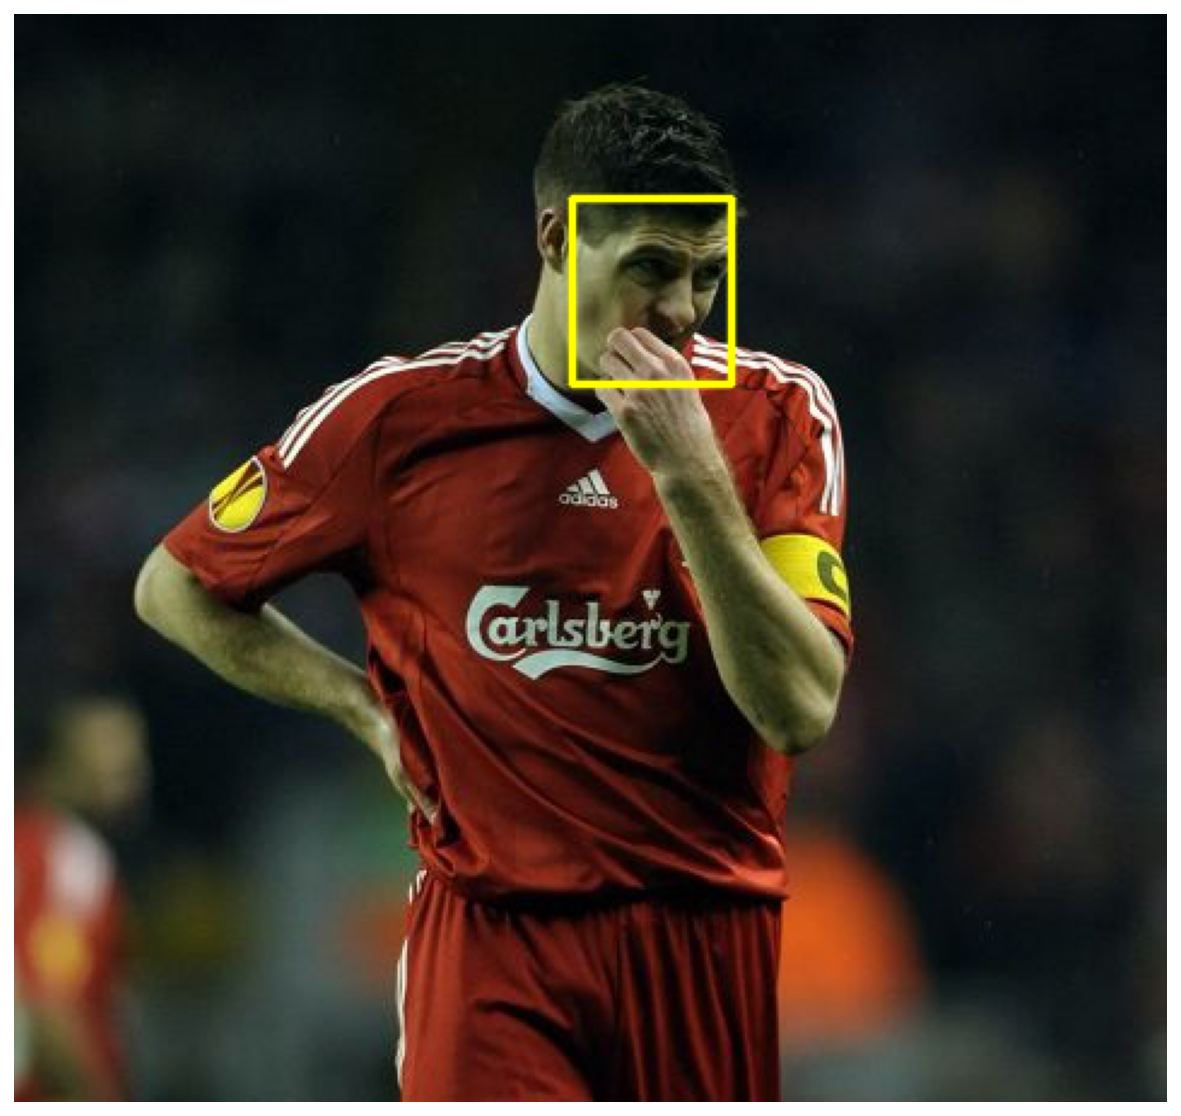

In [ ]:
show_image_objects(train_df.iloc[11])

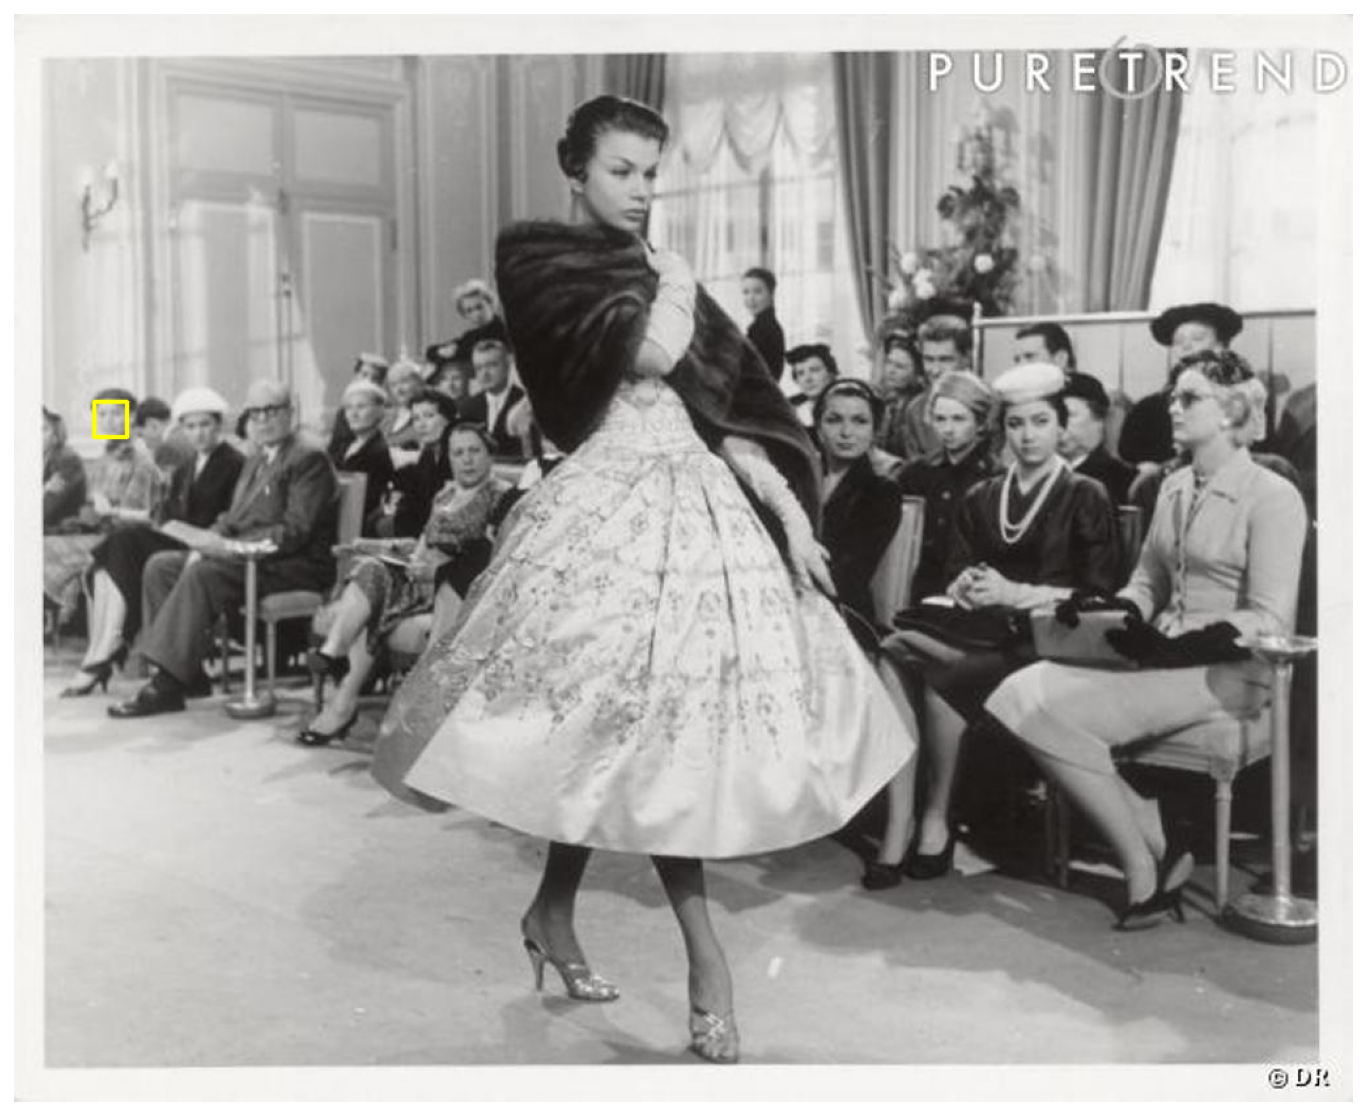

In [ ]:
show_image_objects(train_df.iloc[1113])

In [ ]:
ANNOTATIONS_FILE = 'annotations.csv'
CLASSES_FILE = 'classes.csv'

In [ ]:
train_df.to_csv(ANNOTATIONS_FILE, index=False, header=None)

In [ ]:
!head annotations.csv

/content/drive/My Drive/Unreal_AI/COVID-19/training/images/41_Swimming_Swimmer_41_488.jpg,460,234,574,414,face
/content/drive/My Drive/Unreal_AI/COVID-19/training/images/52_Photographers_photographertakingphoto_52_725.jpg,435,216,630,531,face
/content/drive/My Drive/Unreal_AI/COVID-19/training/images/test_00001091.jpg,347,416,442,553,face_mask
/content/drive/My Drive/Unreal_AI/COVID-19/training/images/test_00004857.jpg,163,87,322,335,face_mask
/content/drive/My Drive/Unreal_AI/COVID-19/training/images/13_Interview_Interview_Sequences_13_164.jpg,356,62,416,158,face
/content/drive/My Drive/Unreal_AI/COVID-19/training/images/13_Interview_Interview_Sequences_13_164.jpg,648,140,718,246,face
/content/drive/My Drive/Unreal_AI/COVID-19/training/images/9_Press_Conference_Press_Conference_9_595.jpg,252,156,576,610,face
/content/drive/My Drive/Unreal_AI/COVID-19/training/images/test_00004658.jpg,159,58,199,109,face_mask
/content/drive/My Drive/Unreal_AI/COVID-19/training/images/test_00004658.jpg,

In [ ]:
df["class_name"].unique()

array(['face', 'face_mask'], dtype=object)

In [ ]:
classes = set(['face', 'face_mask'])

with open(CLASSES_FILE, 'w') as f:
  for i, line in enumerate(sorted(classes)):
    f.write('{},{}\n'.format(line,i))

In [ ]:
len(classes)

2

In [ ]:
!head classes.csv

face,0
face_mask,1


In [ ]:
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to ./snapshots/_pretrained_model.h5


In [ ]:
!apt-get install libjemalloc-dev export LD_PRELOAD="/usr/lib/x86_64-linux-gnu/libjemalloc.so.1"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package export
E: Unable to locate package LD_PRELOAD=/usr/lib/x86_64-linux-gnu


In [ ]:
!apt install chromium-chromedriver

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  chromium-browser chromium-browser-l10n chromium-codecs-ffmpeg-extra
Suggested packages:
  webaccounts-chromium-extension unity-chromium-extension adobe-flashplugin
The following NEW packages will be installed:
  chromium-browser chromium-browser-l10n chromium-chromedriver
  chromium-codecs-ffmpeg-extra
0 upgraded, 4 newly installed, 0 to remove and 31 not upgraded.
Need to get 77.3 MB of archives.
After this operation, 264 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-codecs-ffmpeg-extra amd64 81.0.4044.138-0ubuntu0.18.04.1 [1,095 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-browser amd64 81.0.4044.138-0ubuntu0.18.04.1 [68.9 MB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-browser-l10n all 81.0.4

In [ ]:
!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 8 --steps 500 --epochs 30 csv annotations.csv classes.csv

Using TensorFlow backend.
Creating model, this may take a second...
2020-05-25 07:17:45.649750: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-25 07:17:45.652114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-05-25 07:17:45.652521: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2020-05-25 07:17:45.652803: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-05-25 07:17:45.654443: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas

In [ ]:
!ls snapshots    

_pretrained_model.h5  resnet50_csv_11.h5  resnet50_csv_22.h5
resnet50_csv_01.h5    resnet50_csv_12.h5  resnet50_csv_23.h5
resnet50_csv_02.h5    resnet50_csv_13.h5  resnet50_csv_24.h5
resnet50_csv_03.h5    resnet50_csv_14.h5  resnet50_csv_25.h5
resnet50_csv_04.h5    resnet50_csv_15.h5  resnet50_csv_26.h5
resnet50_csv_05.h5    resnet50_csv_16.h5  resnet50_csv_27.h5
resnet50_csv_06.h5    resnet50_csv_17.h5  resnet50_csv_28.h5
resnet50_csv_07.h5    resnet50_csv_18.h5  resnet50_csv_29.h5
resnet50_csv_08.h5    resnet50_csv_19.h5  resnet50_csv_30.h5
resnet50_csv_09.h5    resnet50_csv_20.h5
resnet50_csv_10.h5    resnet50_csv_21.h5


In [ ]:
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
print(model_path)

model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

labels_to_names = pd.read_csv(CLASSES_FILE, header=None).T.loc[0].to_dict()

snapshots/resnet50_csv_30.h5
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [